# **Operations to be done with google drive**

ImportError: cannot import name 'drive' from 'google' (unknown location)

# **Data Processing**

In [1]:
#@title Requirements

import tensorflow as tf
import os

In [2]:
#@title Choosing Resources

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
   tf.config.experimental.set_memory_growth(gpu, True)

In [25]:
#@title Data Cleansing

import cv2
import imghdr
from matplotlib import pyplot as plt

data_dir = ['Dataset_img']

image_exts = ['jpg', 'jpeg', 'png', 'bmp']

for i in data_dir:
    for image_class in os.listdir(i):
        for image in os.listdir(os.path.join(i, image_class)):
            image_path = os.path.join(i, image_class, image)
            try:
                img = cv2.imread(image_path)
                tip = imghdr.what(image_path)
                if tip not in image_exts:
                    print('Image not in ext list {}'.format(image_path))
                    os.remove(image_path)
            except Exception as e:
                print('Issue with image {}'.format(image_path))

Found 1097 files belonging to 3 classes.


Batch classes:  [1 1 1 2 1 2 2 2 2 1 1 1 2 1 1 1 1 1 2 0 1 1 2 1 1 2 2 2 2 1 2 0]


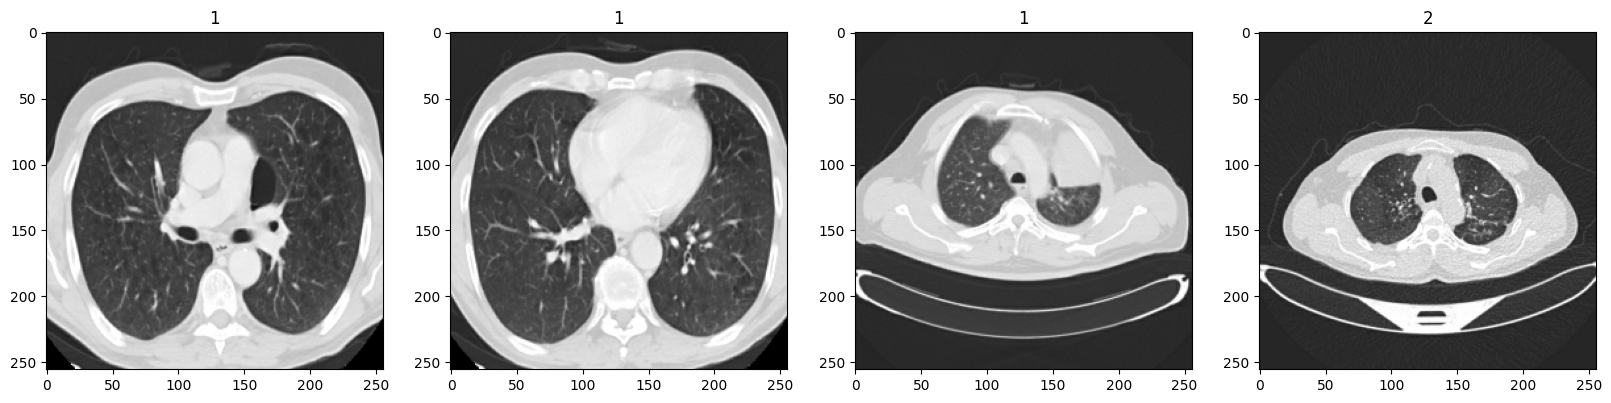

In [26]:
#@title Creating Data Pipeline
import numpy as np

data = tf.keras.utils.image_dataset_from_directory('Dataset_img', shuffle=True)

data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
print("Batch classes: ", batch[1])
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [27]:
#@title Preprocessing Data

''' Scaling Data '''
# Scaling Data
data = data.map(lambda x,y: (x/255, y))
data.as_numpy_iterator().next()[0].max()


''' Splitting Data '''
train_size = int(len(data)*.7)
val_size = int(len(data)*.1)
test_size = int(len(data)*.2)+1

train = data.take(train_size)
val = data.take(val_size)
test = data.take(test_size)

print(train_size, "+", test_size, "+", val_size, "=", len(data))

24 + 8 + 3 = 35


# **Deep Learning Models Creation, Training, Evaluating, Saving, Performance Graph etc.**

In [6]:
#@title Deep Models XceptionNet, InceptionResnetV2, MobileNetV2

''' Deep Model '''
# The Network
import keras.backend as K
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten, Dropout, AveragePooling2D, Concatenate, GlobalAveragePooling2D, BatchNormalization, ReLU, Add, SeparableConv2D
from tensorflow.keras.applications import MobileNetV2, InceptionResNetV2, Xception


def xception(img_shape, n_classes):
    xceptionnet = Xception(input_shape=img_shape, include_top=False, weights='imagenet')
    xceptionnet.trainable = False

    input = Input(img_shape)
    x = xceptionnet(input, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(rate = 0.2)(x)

    output = Dense(n_classes, activation='softmax')(x)

    model = Model(input, output)
    return model





def inceptionresnetv2(img_shape, n_classes):
    inceptionresnet = InceptionResNetV2(input_shape=img_shape, include_top=False, weights='imagenet')
    inceptionresnet.trainable = False

    input = Input(img_shape)
    x = inceptionresnet(input, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(rate = 0.2)(x)

    output = Dense(n_classes, activation='softmax')(x)

    model = Model(input, output)
    return model







def mobilenetv2(img_shape, n_classes):
    mobilenet = MobileNetV2(input_shape=img_shape, include_top=False, weights='imagenet')
    mobilenet.trainable = False

    input = Input(img_shape)
    x = mobilenet(input, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(rate = 0.2)(x)

    output = Dense(n_classes, activation='softmax')(x)

    model = Model(input, output)
    return model




input_shape = (256, 256, 3)
n_classes = 3

from keras.optimizers import SGD
opt = SGD(learning_rate=0.1)

model1 = xception(input_shape, n_classes)
model1.compile('Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model1.summary()

model2 = inceptionresnetv2(input_shape, n_classes)
model2.compile('Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model2.summary()

model3 = mobilenetv2(input_shape, n_classes)
model3.compile('Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model3.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 8, 8, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         6,147 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,867,627 (79.60 MB)

 Trainable params: 6,147 (24.01 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_resnet_v2             │ (None, 6, 6, 1536)     │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         4,611 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,341,347 (207.30 MB)

 Trainable params: 4,611 (18.01 KB)

 Non-trainable params: 54,336,736 (207.28 MB)

C:\Users\ADmin\AppData\Local\Temp\ipykernel_17656\3260267554.py:50: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNetV2(input_shape=img_shape, include_top=False, weights='imagenet')


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [7]:
#@title Training the Models

# Train
logdir='logs'
tensorboard_callback1 = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist1 = model1.fit(train, epochs=60, validation_data=val, callbacks=[tensorboard_callback1])
print(hist1.history)

tensorboard_callback2 = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist2 = model2.fit(train, epochs=60, validation_data=val, callbacks=[tensorboard_callback2])
print(hist2.history)

tensorboard_callback3 = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist3 = model3.fit(train, epochs=60, validation_data=val, callbacks=[tensorboard_callback3])
print(hist3.history)

Epoch 1/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 103s 4s/step - accuracy: 0.5863 - loss: 0.9068 - val_accuracy: 0.8438 - val_loss: 0.4879
Epoch 2/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.8301 - loss: 0.5083 - val_accuracy: 0.8646 - val_loss: 0.3890
Epoch 3/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.8477 - loss: 0.4106 - val_accuracy: 0.8229 - val_loss: 0.4256
Epoch 4/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.8654 - loss: 0.3639 - val_accuracy: 0.8021 - val_loss: 0.4157
Epoch 5/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.8558 - loss: 0.3431 - val_accuracy: 0.8646 - val_loss: 0.2922
Epoch 6/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - accuracy: 0.8785 - loss: 0.3205 - val_accuracy: 0.9271 - val_loss: 0.1840
Epoch 7/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.8841 - loss: 0.3015 - val_accuracy: 0.8854 - val_loss: 0.2494
Epoch 8/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.8954 - loss: 0.2668 - val_accuracy: 0.9167 - val_loss

8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9946 - loss: 0.0518
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9737 - loss: 0.1251
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 846ms/step - accuracy: 0.9914 - loss: 0.0458
Result1 : 
 0.9921875 
Result2 : 
 0.9765625 
Result3 : 
 0.98828125
Loss1: 
 0.05921044573187828 
Loss2: 
 0.11443029344081879 
Loss3: 
 0.05134652554988861
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Precision:1.0, Recall:1.0, Accuracy (Binary):0.59375, Accuracy (sparse_categorical):[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]
Confusion Matrix for Model 1: 
 [[ 2  0  0]
 [ 0 17  0]
 [ 0  0 13]]


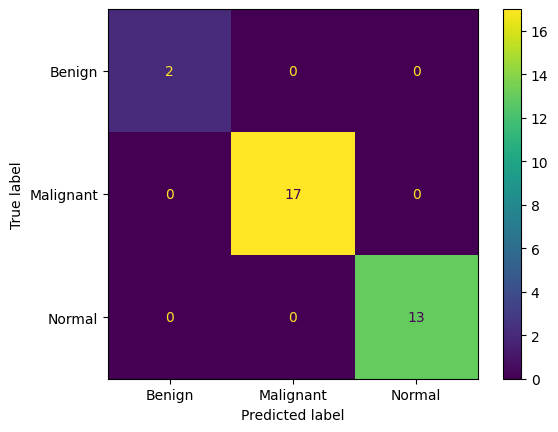

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Precision:0.8958333134651184, Recall:0.9347826242446899, Accuracy (Binary):0.4765625, Accuracy (sparse_categorical):[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]
Confusion Matrix for Model 2: 
 [[0 1 0]
 [1 8 8]
 [1 8 5]]


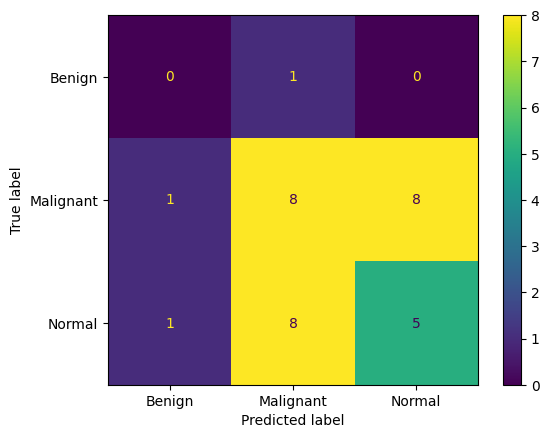

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 840ms/step
Precision:0.875, Recall:0.9375, Accuracy (Binary):0.5, Accuracy (sparse_categorical):[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]
Confusion Matrix for Model 3: 
 [[1 3 0]
 [0 6 9]
 [1 8 4]]


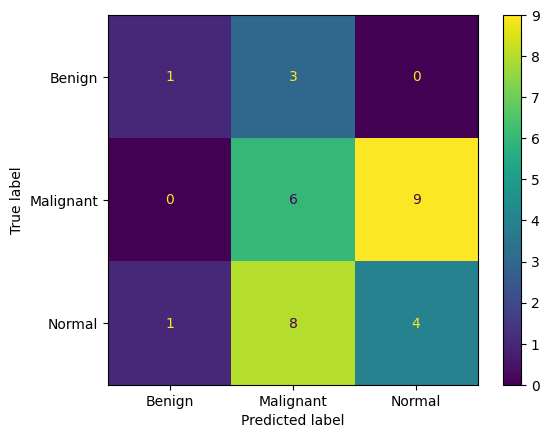

In [8]:
#@title Evaluating the Models

''' Evaluation '''
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, sparse_categorical_accuracy
from sklearn.metrics import *

loss1, results1 = model1.evaluate(test, batch_size=328, callbacks=[tensorboard_callback1])
loss2, results2 = model2.evaluate(test, batch_size=328, callbacks=[tensorboard_callback2])
loss3, results3 = model3.evaluate(test, batch_size=328, callbacks=[tensorboard_callback3])
print("Result1 : \n", results1, "\nResult2 : \n", results2, "\nResult3 : \n", results3)
print("Loss1: \n", loss1, "\nLoss2: \n", loss2, "\nLoss3: \n", loss3)

pre1 = Precision()
re1 = Recall()
acc1 = BinaryAccuracy()
for batch1 in test.as_numpy_iterator():
    X1, y1 = batch1
    yhat1 = model1.predict(X1)
    max = a = 0
    arr = np.ones(yhat1.shape[0])*-1
    for i in yhat1:
        if ((i[0] > i[1]) and (i[0] > i[2])):
            max = 0
        elif ((i[1] > i[0]) and (i[1] > i[2])):
            max = 1
        else:
            max = 2
        arr[a] = max
        a+=1
    pre1.update_state(y1, arr)
    re1.update_state(y1, arr)
    acc1.update_state(y1, arr)
acc11 = sparse_categorical_accuracy(y1, yhat1)
assert acc11.shape == (y1.shape[0],)
print(f'Precision:{pre1.result().numpy()}, Recall:{re1.result().numpy()}, Accuracy (Binary):{acc1.result().numpy()}, Accuracy (sparse_categorical):{acc11.numpy()}')
matrix = confusion_matrix(y1, arr)
print("Confusion Matrix for Model 1: \n", matrix)
display = ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = ['Benign', 'Malignant', 'Normal'])
display.plot()
plt.show()

pre2 = Precision()
re2 = Recall()
acc2 = BinaryAccuracy()
for batch2 in test.as_numpy_iterator():
    X2, y2 = batch2
    yhat2 = model2.predict(X2)
    max = a = 0
    arr = np.ones(yhat2.shape[0])*-1
    for i in yhat1:
        if ((i[0] > i[1]) and (i[0] > i[2])):
            max = 0
        elif ((i[1] > i[0]) and (i[1] > i[2])):
            max = 1
        else:
            max = 2
        arr[a] = max
        a+=1
    pre2.update_state(y2, arr)
    re2.update_state(y2, arr)
    acc2.update_state(y2, arr)
acc21 = sparse_categorical_accuracy(y2, yhat2)
assert acc21.shape == (y2.shape[0],)
print(f'Precision:{pre2.result().numpy()}, Recall:{re2.result().numpy()}, Accuracy (Binary):{acc2.result().numpy()}, Accuracy (sparse_categorical):{acc21.numpy()}')
matrix = confusion_matrix(y2, arr)
print("Confusion Matrix for Model 2: \n", matrix)
display = ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = ['Benign', 'Malignant', 'Normal'])
display.plot()
plt.show()

pre3 = Precision()
re3 = Recall()
acc3 = BinaryAccuracy()
for batch3 in test.as_numpy_iterator():
    X3, y3 = batch3
    yhat3 = model3.predict(X3)
    max = a = 0
    arr = np.ones(yhat3.shape[0])*-1
    for i in yhat1:
        if ((i[0] > i[1]) and (i[0] > i[2])):
            max = 0
        elif ((i[1] > i[0]) and (i[1] > i[2])):
            max = 1
        else:
            max = 2
        arr[a] = max
        a+=1
    pre3.update_state(y3, arr)
    re3.update_state(y3, arr)
    acc3.update_state(y3, arr)
acc31 = sparse_categorical_accuracy(y3, yhat3)
assert acc31.shape == (y3.shape[0],)
print(f'Precision:{pre3.result().numpy()}, Recall:{re3.result().numpy()}, Accuracy (Binary):{acc3.result().numpy()}, Accuracy (sparse_categorical):{acc31.numpy()}')
matrix = confusion_matrix(y3, arr)
print("Confusion Matrix for Model 3: \n", matrix)
display = ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = ['Benign', 'Malignant', 'Normal'])
display.plot()
plt.show()

In [16]:
#@title Saving the Models and their Histories

import pickle


# Saving the Models

model1.save(os.path.join('models','imageclassifier1.keras'))
model2.save(os.path.join('models','imageclassifier2.h5'))
model3.save(os.path.join('models','imageclassifier3.keras'))


# Saving the Model Histories

with open(os.path.join(logdir+'/history1.pkl'), 'wb') as file:
    pickle.dump(hist1.history, file)

with open(os.path.join(logdir+'/history2.pkl'), 'wb') as file:
    pickle.dump(hist2.history, file)

with open(os.path.join(logdir+'/history3.pkl'), 'wb') as file:
    pickle.dump(hist3.history, file)

ValueError: Unable to synchronously create dataset (name already exists)

In [18]:
#@title Re-Loading the Models and their Histories

import pickle
from tensorflow.keras.models import load_model


logdir='logs'

# Loading the Models
model1 = load_model('models/imageclassifier1.keras')
model2 = load_model('models/imageclassifier2.keras')
model3 = load_model('models/imageclassifier3.keras')


# Loading the Model Histories

with open(os.path.join(logdir+'/history1.pkl'), 'rb') as file:
    hist1 = pickle.load(file)

with open(os.path.join(logdir+'/history2.pkl'), 'rb') as file:
    hist2 = pickle.load(file)

with open(os.path.join(logdir+'/history3.pkl'), 'rb') as file:
    hist3 = pickle.load(file)
     

c:\Users\ADmin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 158 variables whereas the saved optimizer has 6 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))



c:\Users\ADmin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 982 variables whereas the saved optimizer has 6 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
c:\Users\ADmin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 160 variables whereas the saved optimizer has 6 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


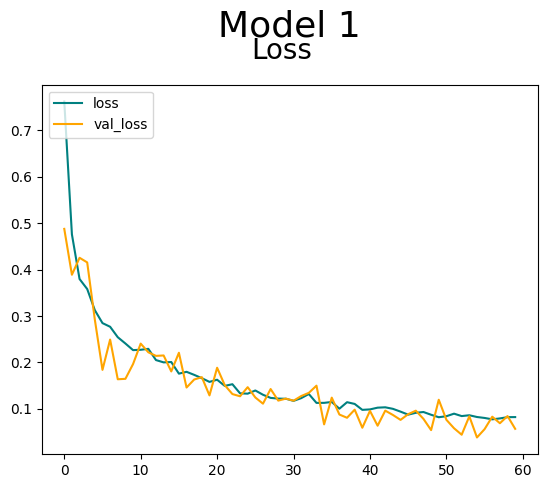

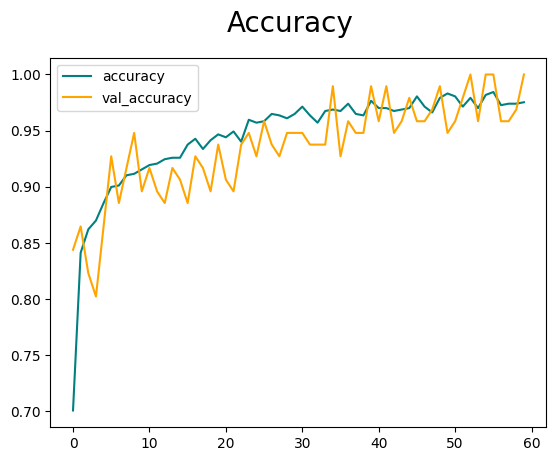

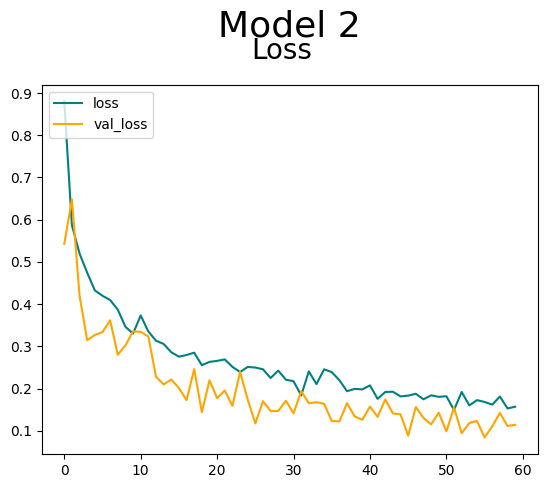

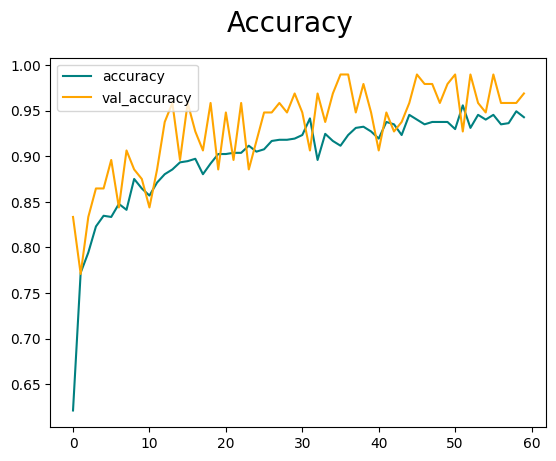

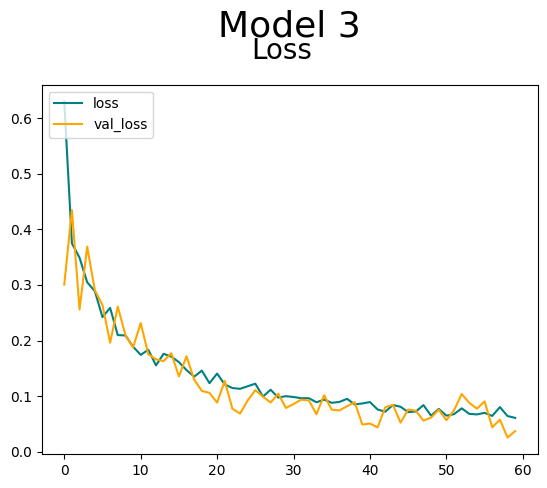

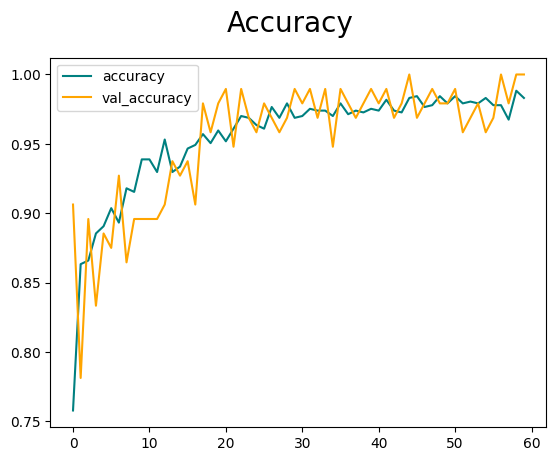

In [20]:
#@title Performance Graphs

import matplotlib.pyplot as plt

''' Model 1 '''
# Loss
fig = plt.figure()
plt.title("Model 1\n", loc='center', fontsize=26)
plt.plot(hist1['loss'], color='teal', label='loss')
plt.plot(hist1['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Accuracy
fig = plt.figure()
plt.plot(hist1['accuracy'], color='teal', label='accuracy')
plt.plot(hist1['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

''' Model 1 '''

# Loss
fig = plt.figure()
plt.title("Model 2\n", loc='center', fontsize=26)
plt.plot(hist2['loss'], color='teal', label='loss')
plt.plot(hist2['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Accuracy
fig = plt.figure()
plt.plot(hist2['accuracy'], color='teal', label='accuracy')
plt.plot(hist2['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# ''' Model 3 '''
# Loss
fig = plt.figure()
plt.title("Model 3\n", loc='center', fontsize=26)
plt.plot(hist3['loss'], color='teal', label='loss')
plt.plot(hist3['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Accuracy
fig = plt.figure()
plt.plot(hist3['accuracy'], color='teal', label='accuracy')
plt.plot(hist3['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

Xception : 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 2 0 0 2 0 2 0 0 0 0 2 0 2 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

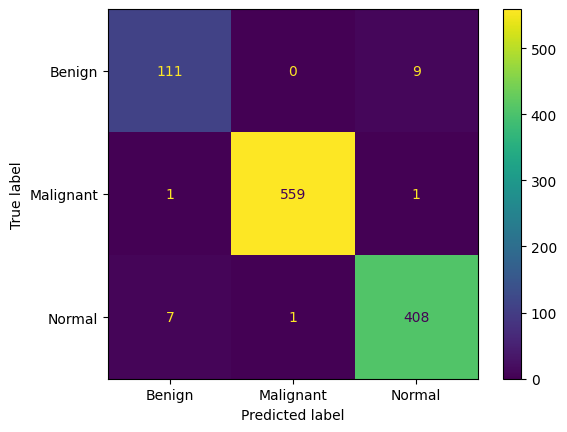

Precision:0.9788092970848083, Recall:0.9928352236747742, Accuracy (Binary):0.59981769323349
Confusion Matrix for Model 2: 
 [[ 99   0  21]
 [  2 557   2]
 [  5   6 405]]


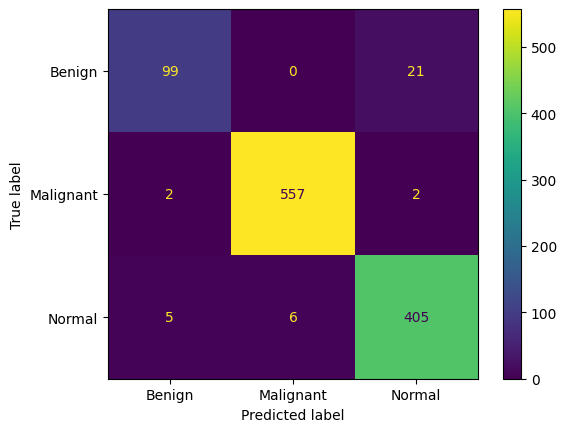

Precision:0.9809045195579529, Recall:0.998976469039917, Accuracy (Binary):0.6034640073776245
Confusion Matrix for Model 3: 
 [[101   0  19]
 [  0 561   0]
 [  1   0 415]]


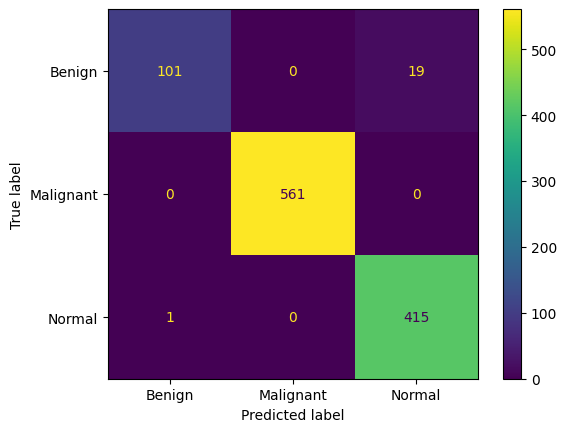

In [21]:
#@title Precision, Recall and Accuracy of the Models with respect to all images in dataset

from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, sparse_categorical_accuracy
from sklearn.metrics import *

labels = []; p1 = []; p2 = []; p3 = []
pre1 = Precision()
re1 = Recall()
acc1 = BinaryAccuracy()
for j in data_dir:
    for c, image_class in enumerate(os.listdir(j)):
        for image in os.listdir(os.path.join(j, image_class)):
            image_path = os.path.join(j, image_class, image)
            img = cv2.imread(image_path)
            resize = tf.image.resize(img, (256, 256))

            yhat1 = model1.predict(np.expand_dims(resize/255, 0), verbose=0)
            yhat2 = model2.predict(np.expand_dims(resize/255, 0), verbose=0)
            yhat3 = model3.predict(np.expand_dims(resize/255, 0), verbose=0)
            max = 0
            for i in yhat1:
                if ((i[0] > i[1]) and (i[0] > i[2])):
                    max = 0
                elif ((i[1] > i[0]) and (i[1] > i[2])):
                    max = 1
                else:
                    max = 2
                p1.append(max)

            max = 0
            for i in yhat2:
                if ((i[0] > i[1]) and (i[0] > i[2])):
                    max = 0
                elif ((i[1] > i[0]) and (i[1] > i[2])):
                    max = 1
                else:
                    max = 2
                p2.append(max)

            max = 0
            for i in yhat3:
                if ((i[0] > i[1]) and (i[0] > i[2])):
                    max = 0
                elif ((i[1] > i[0]) and (i[1] > i[2])):
                    max = 1
                else:
                    max = 2
                p3.append(max)

            labels.append(c)

labels = np.asarray(labels)
p1 = np.asarray(p1)
p2 = np.asarray(p2)
p3 = np.asarray(p3)

print("Xception : ", end="")
for i in p1:
    print(i, end=" ")
print("\nInceptionResNetV2 : ", end="")
for i in p2:
    print(i, end = " ")
print("\nMobileNetV2 : ", end="")
for i in p3:
    print(i, end=" ")
print()

pre1.update_state(labels, p1)
re1.update_state(labels, p1)
acc1.update_state(labels, p1)
print(f'Precision:{pre1.result().numpy()}, Recall:{re1.result().numpy()}, Accuracy (Binary):{acc1.result().numpy()}')
matrix = confusion_matrix(labels, p1)
print("Confusion Matrix for Model 1: \n", matrix)
display = ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = ['Benign', 'Malignant', 'Normal'])
display.plot()
plt.show()

pre1 = Precision()
re1 = Recall()
acc1 = BinaryAccuracy()
pre1.update_state(labels, p2)
re1.update_state(labels, p2)
acc1.update_state(labels, p2)
print(f'Precision:{pre1.result().numpy()}, Recall:{re1.result().numpy()}, Accuracy (Binary):{acc1.result().numpy()}')
matrix = confusion_matrix(labels, p2)
print("Confusion Matrix for Model 2: \n", matrix)
display = ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = ['Benign', 'Malignant', 'Normal'])
display.plot()
plt.show()

pre1 = Precision()
re1 = Recall()
acc1 = BinaryAccuracy()
pre1.update_state(labels, p3)
re1.update_state(labels, p3)
acc1.update_state(labels, p3)
print(f'Precision:{pre1.result().numpy()}, Recall:{re1.result().numpy()}, Accuracy (Binary):{acc1.result().numpy()}')
matrix = confusion_matrix(labels, p3)
print("Confusion Matrix for Model 3: \n", matrix)
display = ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = ['Benign', 'Malignant', 'Normal'])
display.plot()
plt.show()

# **Predictions by each model and Probability Extraction for Fuzzy Ensemble of Deep Neural Networks**

In [29]:
#@title Predictions of each Model and Probability Extraction from Models

# Getting Probability Distribution

print("\nGetting the Probability Distribution")
loss1, results1 = model1.evaluate(test, batch_size=328, callbacks=[tensorboard_callback1])
loss2, results2 = model2.evaluate(test, batch_size=328, callbacks=[tensorboard_callback2])
loss3, results3 = model3.evaluate(test, batch_size=328, callbacks=[tensorboard_callback3])
print("Result1 : \n", results1, "\nResult2 : \n", results2, "\nResult3 : \n", results3)
print("Loss1: \n", loss1, "\nLoss2: \n", loss2, "\nLoss3: \n", loss3)

predictions11 = model1.predict(test, batch_size=328, callbacks=[tensorboard_callback1])
predictions21 = model2.predict(test, batch_size=328, callbacks=[tensorboard_callback2])
predictions31 = model3.predict(test, batch_size=328, callbacks=[tensorboard_callback3])

predictions1 = model1.predict(train)
prediction_classes = [1 if ((prob[1] > prob[0]) and (prob[1] > prob[2])) else 2 if ((prob[2] > prob[0]) and (prob[2] > prob[1])) else 0 for prob in predictions1]
print(np.ravel(predictions1))
print("Model 1 : \n", prediction_classes)

predictions2 = model2.predict(train)
prediction_classes = [1 if ((prob[1] > prob[0]) and (prob[1] > prob[2])) else 2 if ((prob[2] > prob[0]) and (prob[2] > prob[1])) else 0 for prob in predictions2]
print("Model 2 : \n", prediction_classes)

predictions3 = model3.predict(train)
prediction_classes = [1 if ((prob[1] > prob[0]) and (prob[1] > prob[2])) else 2 if ((prob[2] > prob[0]) and (prob[2] > prob[1])) else 0 for prob in predictions3]
print("Model 3 : \n", prediction_classes)


p1 = []
p2 = []
p3 = []
for i in data_dir:
    for image_class in os.listdir(i):
        for image in os.listdir(os.path.join(i, image_class)):
            image_path = os.path.join(i, image_class, image)
            img = cv2.imread(image_path)
            resize = tf.image.resize(img, (256, 256))

            yhat1 = model1.predict(np.expand_dims(resize/255, 0))
            yhat2 = model2.predict(np.expand_dims(resize/255, 0))
            yhat3 = model3.predict(np.expand_dims(resize/255, 0))

            p1.append(yhat1[0])
            p2.append(yhat2[0])
            p3.append(yhat3[0])

p1 = np.array(p1)
p2 = np.array(p2)
p3 = np.array(p3)

import csv
fp = open("csv/xceptionnet.csv",'w+',newline = '')
writer = csv.writer(fp)
for i in p1:
    writer.writerow([i[0], i[1], i[2]])
fp.close()

fp = open("csv/inceptionresnet.csv",'w+',newline = '')
writer = csv.writer(fp)
for i in p2:
    writer.writerow([i[0], i[1], i[2]])
fp.close()

fp = open("csv/mobilenetv2.csv",'w+',newline = '')
writer = csv.writer(fp)
for i in p3:
    writer.writerow([i[0], i[1], i[2]])
fp.close()


Getting the Probability Distribution
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.9914 - loss: 0.0589
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.9649 - loss: 0.1476
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 736ms/step - accuracy: 0.9840 - loss: 0.0823
Result1 : 
 0.98828125 
Result2 : 
 0.96484375 
Result3 : 
 0.984375
Loss1: 
 0.07430900633335114 
Loss2: 
 0.13693693280220032 
Loss3: 
 0.07202182710170746
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 737ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step
[1.8773514e-01 3.3174618e-04 8.1193310e-01 ... 6.0037597e-05 9.9991560e-01
 2.4377836e-05]
Model 1 : 
 [2, 1, 2, 1, 0, 2, 2, 0, 1, 2, 1, 1, 1, 2, 2, 1, 0, 1, 2, 1, 2, 2, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 0, 0, 1, 2, 0, 0, 2, 2, 1, 1, 2, 1, 0, 0, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2, 0, 2, 2, 0, 2, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 

In [52]:
import cv2
import numpy as np
import tensorflow as tf

p1 = []
p3 = []

for i in data_dir1:
    for image_class in os.listdir(i):
        for image in os.listdir(os.path.join(i, image_class)):
            image_path = os.path.join(i, image_class, image)
            img = cv2.imread(image_path)
            resize = tf.image.resize(img, (256, 256))  # Sử dụng cv2.resize() thay vì tf.image.resize()

            yhat1 = model1.predict(np.expand_dims(resize/255, 0))
            # yhat2 = model2.predict(np.expand_dims(resize/255, 0))
            yhat3 = model3.predict(np.expand_dims(resize/255, 0))

            p1.append(yhat1[0])
            # p2.append(yhat2[0])
            p3.append(yhat3[0])

p1 = np.array(p1)
# p2 = np.array(p2)
p3 = np.array(p3)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/s

In [30]:
#@title ROC-AUC Curves

import pandas as pd
import numpy as np
from sklearn.metrics import *
import math, os
from sklearn.preprocessing import label_binarize

#ROC-AUC
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt
def plot_roc(val_label,decision_val, caption='ROC Curve'):
    num_classes=np.unique(val_label).shape[0]
    classes = []
    for i in range(num_classes):
        classes.append(i)
    plt.figure()
    decision_val = label_binarize(decision_val, classes=classes)

    if num_classes!=2:
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(num_classes):
            y_val = label_binarize(val_label, classes=classes)
            fpr[i], tpr[i], _ = roc_curve(y_val[:, i], decision_val[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        for i in range(num_classes):
            plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                           ''.format(i+1, roc_auc[i]))
    else:
        fpr,tpr,_ = roc_curve(val_label,decision_val, pos_label=1)
        roc_auc = auc(fpr,tpr)*100
        plt.plot(fpr,tpr,label='ROC curve (AUC=%0.2f)'%roc_auc)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(caption)
    plt.legend(loc="lower right")
    plt.savefig(str(len(classes))+'.png',dpi=300)

def predicting(ensemble_prob):
    prediction = np.zeros((ensemble_prob.shape[0],))
    for i in range(ensemble_prob.shape[0]):
        temp = ensemble_prob[i]
        t = np.where(temp == np.max(temp))[0][0]
        prediction[i] = t
    return prediction

def metrics(labels, predictions,classes):
    print("Classification Report:")
    print("Labels : ",labels.shape, '\nPredictions : ', predictions.shape)
    print(classification_report(labels, predictions, target_names = classes, digits = 4))
    matrix = confusion_matrix(labels, predictions)
    print("Confusion matrix:")
    print(matrix)
    display = ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = ['Benign', 'Malignant', 'Normal'])
    display.plot()
    plt.show()
    print("\nClasswise Accuracy :{}".format(matrix.diagonal()/matrix.sum(axis = 1)))
    print("\nBalanced Accuracy Score: ",balanced_accuracy_score(labels,predictions))

## ***Fuzzy Ensemble using Mitcherlich Function***

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 2 2 2 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

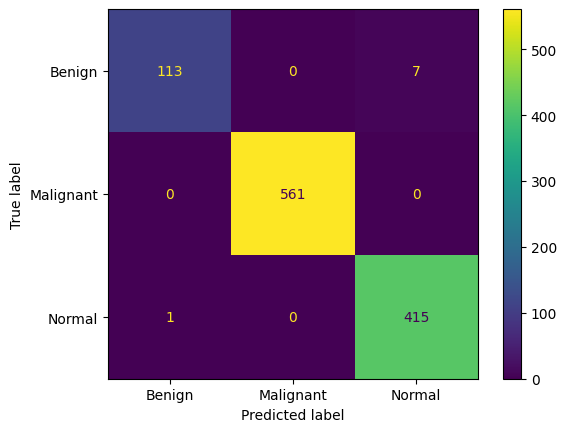


Classwise Accuracy :[0.94166667 1.         0.99759615]

Balanced Accuracy Score:  0.9797542735042736
Accuracy[0.9927] Precision[0.9915] Recall[0.9798] F1[0.9854] ]
________________________________________________________________


Overall Accuracy[0.9927] Overall Precision[0.9915] Overall Recall[0.9798] Overall F1[0.9854]


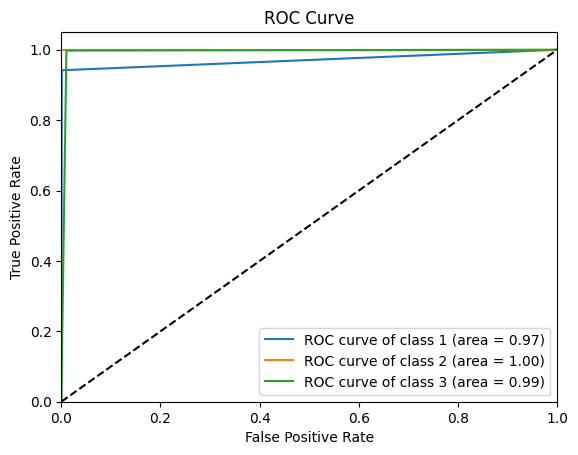

In [31]:
#@title Predictions with Mitcherlich Function

import pandas as pd
import math
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def fuzzy_rank(CF, top):
    R_L = np.zeros(CF.shape)
    for i in range(CF.shape[0]):
        for j in range(CF.shape[1]):
            for k in range(CF.shape[2]):
                R_L[i][j][k] = (2 - 1 * 2 ** CF[i][j][k])

    K_L = 1*np.ones(shape = R_L.shape)
    for i in range(R_L.shape[0]):
        for sample in range(R_L.shape[1]):
            for k in range(top-1):
                a = R_L[i][sample]
                idx = np.where(a==np.partition(a, k)[k])
                K_L[i][sample][idx] = R_L[i][sample][idx]

    return K_L

def CFS_func(CF, K_L):
    H = CF.shape[0]
    for f in range(CF.shape[0]):
        for i in range(CF.shape[1]):
            idx = np.where(K_L[f][i] == 1)
            CF[f][i][idx] = 0
    CFS = 1 - np.sum(CF,axis=0)/H
    return CFS

def Mitcherlich(top = 2, *argv):
    L = 0
    for arg in argv:
        L += 1

    num_classes = arg.shape[1]
    CF = np.zeros(shape = (L,arg.shape[0], arg.shape[1]))

    for i, arg in enumerate(argv):
        CF[:][:][i] = arg

    R_L = fuzzy_rank(CF, top)

    RS = np.sum(R_L, axis=0)
    CFS = CFS_func(CF, R_L)
    FS = RS*CFS


    predictions = np.argmin(FS,axis=1)
    return predictions

def getfile(filename):
    root='csv/'
    file = root+filename
    if '.csv' not in filename:
        file = file+'.csv'
    df = pd.read_csv(file,header=None)
    df = np.asarray(df)

    labels=[]
    for k in data_dir:
        for i, c in enumerate(os.listdir(k)):
            for j in range(len(os.listdir(k+"/"+c))):
                labels.append(i)
    labels = np.asarray(labels)
    return df,labels

p1,labels = getfile("xceptionnet")
# p2,_ = getfile("inceptionresnet")
p3,_ = getfile("mobilenetv2")

predictions = Mitcherlich(3, p1, p3)
for i in predictions:
    print(i, end=" ")
print()

correct = np.where(predictions == labels)[0].shape[0]
total = labels.shape[0]

classes = []
for i in range(p1.shape[1]):
    classes.append(str(i+1))
print(classes)

metrics(labels, predictions, classes)

plot_roc(labels,predictions)


avg_acc_list = []
avg_precision_list = []
avg_recall_list = []
avg_f1_list = []

acc_fold = accuracy_score(labels, predictions)
avg_acc_list.append(acc_fold)
precision_fold = precision_score(labels, predictions, average='macro')
avg_precision_list.append(precision_fold)
recall_fold = recall_score(labels, predictions, average='macro')
avg_recall_list.append(recall_fold)
f1_fold  = f1_score(labels, predictions, average='macro')
avg_f1_list.append(f1_fold)

print('Accuracy[{:.4f}] Precision[{:.4f}] Recall[{:.4f}] F1[{:.4f}] ]'.format(acc_fold, precision_fold, recall_fold, f1_fold ))
print('________________________________________________________________')

avg_acc = np.asarray(avg_acc_list)
avg_precision = np.asarray(avg_precision_list)
avg_recall = np.asarray(avg_recall_list)
avg_f1 = np.asarray(avg_f1_list)
print("\n")
print('Overall Accuracy[{:.4f}] Overall Precision[{:.4f}] Overall Recall[{:.4f}] Overall F1[{:.4f}]'.format(np.mean(avg_acc), np.mean(avg_precision), np.mean(avg_recall), np.mean(avg_f1)))